In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [19]:
import torchvision
from torchvision import datasets, models, transforms

In [20]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import pandas as pd
import json
import cv2
from PIL import ImageDraw, ImageFont
from collections import namedtuple, OrderedDict

In [21]:
from session import *
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
torch.cuda.is_available(), torch.cuda.get_device_name(0), torch.backends.cudnn.enabled

(True, 'GeForce GTX 960M', True)

In [24]:
DATA_PATH = Path('C:/fastai/courses/dl2/data/road_damage_dataset')

In [25]:
MULTICLASS_CSV_PATH = DATA_PATH/'mc.csv'

In [26]:
im_size = 224

In [27]:
train_tfms = TransformList([
        RandomScale(im_size, 1.2),
        RandomCrop(im_size),
        RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_tfms = TransformList([
        Scale(im_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [28]:
batch_size = 4
data = ImageData.from_csv(DATA_PATH, MULTICLASS_CSV_PATH, batch_size, train_tfms, val_tfms)
num_classes = 8

In [29]:
# next(iter(data['train']))

In [30]:
model_ft = models.resnet18(pretrained=True)
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Dropout(p=.5),
    nn.Linear(num_ftrs, num_classes),
    nn.Sigmoid()
)

In [31]:
criterion = nn.BCELoss()
optim_fn = optim.Adam

In [32]:
sess = Session(model_ft, criterion, optim_fn, [*[1e-3] * 9, 1e-2])

In [33]:
sess.freeze() 

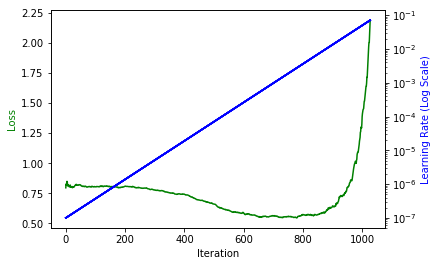

In [34]:
lr_find(sess, data['train'], start_lr=1e-7)

In [35]:
sess.set_lr(1e-3)

In [36]:
accuracy = NHotAccuracy(num_classes)
validator = Validator(data['valid'], accuracy)
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
schedule = TrainingSchedule(data['train'], [validator, lr_scheduler])

sess.train(schedule, 3)

Training Loss: 0.487703  Validaton Loss: 0.398779 Validation Accuracy: 0.827389


Training Loss: 0.491905  Validaton Loss: 0.396891 Validation Accuracy: 0.826498


Training Loss: 0.489567  Validaton Loss: 0.388448 Validation Accuracy: 0.835414


In [37]:
for detail in accuracy.confusion:
    print(detail)

{'correct_pos': 23, 'correct_neg': 1031, 'false_pos': 30, 'false_neg': 318}
{'correct_pos': 152, 'correct_neg': 816, 'false_pos': 56, 'false_neg': 378}
{'correct_pos': 0, 'correct_neg': 1307, 'false_pos': 0, 'false_neg': 95}
{'correct_pos': 2, 'correct_neg': 1299, 'false_pos': 5, 'false_neg': 96}
{'correct_pos': 62, 'correct_neg': 991, 'false_pos': 10, 'false_neg': 339}
{'correct_pos': 4, 'correct_neg': 1329, 'false_pos': 9, 'false_neg': 60}
{'correct_pos': 60, 'correct_neg': 1272, 'false_pos': 13, 'false_neg': 57}
{'correct_pos': 184, 'correct_neg': 838, 'false_pos': 116, 'false_neg': 264}


In [39]:
print("Precision: ", accuracy.precision()) 
print("Recall: ", accuracy.recall())
print("F-Measure: ", accuracy.FMeasure())

Precision:  [0.4339622641509434, 0.7307692307692307, 0, 0.2857142857142857, 0.8611111111111112, 0.3076923076923077, 0.821917808219178, 0.6133333333333333]
Recall:  [0.06744868035190615, 0.28679245283018867, 0, 0.02040816326530612, 0.1546134663341646, 0.0625, 0.5128205128205128, 0.4107142857142857]
F-Measure:  [0.11675126903553298, 0.4119241192411924, 0, 0.038095238095238085, 0.26215644820295986, 0.1038961038961039, 0.631578947368421, 0.4919786096256684]


In [40]:
sess.save('TrainLayer1')

In [41]:
sess.load('TrainLayer1')

In [42]:
sess.unfreeze()

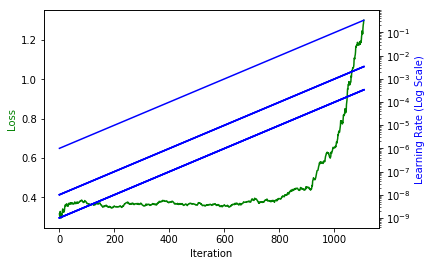

In [56]:
lr_find(sess, data['train'], 
        start_lr=[*[1e-6 / 1000] * 5, *[1e-6 / 100] * 4, 1e-6], 
        end_lr=[*[10 / 1000] * 5, *[10 / 100] * 4, 10])

In [57]:
sess.set_lr([*[1e-4 / 1000] * 5, *[1e-4 / 100] * 4, 1e-4])

In [58]:
accuracy = NHotAccuracy(num_classes)
validator = Validator(data['valid'], accuracy)
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
schedule = TrainingSchedule(data['train'], [validator, lr_scheduler])

sess.train(schedule, 7)

Training Loss: 0.362719  Validaton Loss: 0.353291 Validation Accuracy: 0.853691


Training Loss: 0.361477  Validaton Loss: 0.354081 Validation Accuracy: 0.850125


Training Loss: 0.366281  Validaton Loss: 0.344313 Validation Accuracy: 0.861091


Training Loss: 0.381785  Validaton Loss: 0.363612 Validation Accuracy: 0.849590


Training Loss: 0.363969  Validaton Loss: 0.364280 Validation Accuracy: 0.852800


Training Loss: 0.319443  Validaton Loss: 0.347877 Validation Accuracy: 0.856455


Training Loss: 0.318151  Validaton Loss: 0.341790 Validation Accuracy: 0.858506


In [59]:
for detail in accuracy.confusion:
    print(detail)

{'correct_pos': 116, 'correct_neg': 959, 'false_pos': 102, 'false_neg': 225}
{'correct_pos': 335, 'correct_neg': 692, 'false_pos': 180, 'false_neg': 195}
{'correct_pos': 4, 'correct_neg': 1286, 'false_pos': 21, 'false_neg': 91}
{'correct_pos': 13, 'correct_neg': 1243, 'false_pos': 61, 'false_neg': 85}
{'correct_pos': 193, 'correct_neg': 936, 'false_pos': 65, 'false_neg': 208}
{'correct_pos': 14, 'correct_neg': 1254, 'false_pos': 84, 'false_neg': 50}
{'correct_pos': 108, 'correct_neg': 1269, 'false_pos': 16, 'false_neg': 9}
{'correct_pos': 351, 'correct_neg': 856, 'false_pos': 98, 'false_neg': 97}


In [60]:
print("Precision: ", accuracy.precision()) 
print("Recall: ", accuracy.recall())
print("F-Measure: ", accuracy.FMeasure())

Precision:  [0.5321100917431193, 0.6504854368932039, 0.16, 0.17567567567567569, 0.748062015503876, 0.14285714285714285, 0.8709677419354839, 0.7817371937639198]
Recall:  [0.34017595307917886, 0.6320754716981132, 0.042105263157894736, 0.1326530612244898, 0.48129675810473815, 0.21875, 0.9230769230769231, 0.7834821428571429]
F-Measure:  [0.4150268336314848, 0.6411483253588518, 0.06666666666666667, 0.15116279069767444, 0.5857359635811836, 0.1728395061728395, 0.8962655601659751, 0.7826086956521738]


In [48]:
lr_scheduler.plot()

NameError: name 'copy' is not defined

In [61]:
sess.save('FullTrain')

In [62]:
sess.load('FullTrain')

In [63]:
sess.train(schedule, 8)

Training Loss: 0.351188  Validaton Loss: 0.367203 Validation Accuracy: 0.838267


Training Loss: 0.356208  Validaton Loss: 0.349133 Validation Accuracy: 0.852621


Training Loss: 0.314113  Validaton Loss: 0.373842 Validation Accuracy: 0.844419


Training Loss: 0.281961  Validaton Loss: 0.349886 Validation Accuracy: 0.850303


Training Loss: 0.274582  Validaton Loss: 0.369165 Validation Accuracy: 0.840763


Training Loss: 0.264555  Validaton Loss: 0.349245 Validation Accuracy: 0.853691


Training Loss: 0.244936  Validaton Loss: 0.348136 Validation Accuracy: 0.855296


Training Loss: 0.251675  Validaton Loss: 0.351786 Validation Accuracy: 0.853780


In [64]:
sess.save('FullTrain2')

In [65]:
sess.load('FullTrain2')

In [66]:
print("Precision: ", accuracy.precision()) 
print("Recall: ", accuracy.recall())
print("F-Measure: ", accuracy.FMeasure())

Precision:  [0.46296296296296297, 0.6573556797020484, 0.15702479338842976, 0.21978021978021978, 0.7105263157894737, 0.24561403508771928, 0.8617886178861789, 0.7710583153347732]
Recall:  [0.36656891495601174, 0.6660377358490566, 0.2, 0.20408163265306123, 0.5386533665835411, 0.21875, 0.905982905982906, 0.796875]
F-Measure:  [0.4091653027823241, 0.661668228678538, 0.17592592592592596, 0.21164021164021163, 0.6127659574468085, 0.23140495867768596, 0.8833333333333334, 0.7837541163556532]


In [67]:
for detail in accuracy.confusion:
    print(detail)

{'correct_pos': 125, 'correct_neg': 916, 'false_pos': 145, 'false_neg': 216}
{'correct_pos': 353, 'correct_neg': 688, 'false_pos': 184, 'false_neg': 177}
{'correct_pos': 19, 'correct_neg': 1205, 'false_pos': 102, 'false_neg': 76}
{'correct_pos': 20, 'correct_neg': 1233, 'false_pos': 71, 'false_neg': 78}
{'correct_pos': 216, 'correct_neg': 913, 'false_pos': 88, 'false_neg': 185}
{'correct_pos': 14, 'correct_neg': 1295, 'false_pos': 43, 'false_neg': 50}
{'correct_pos': 106, 'correct_neg': 1268, 'false_pos': 17, 'false_neg': 11}
{'correct_pos': 357, 'correct_neg': 848, 'false_pos': 106, 'false_neg': 91}
